# COVERAGE KNN

### IMPORTS & DATA

In [7]:
import pandas as pd
import numpy as np
import torch
import random
import faiss
from tqdm import tqdm
from typing import List, Tuple, Union
from transformers import EsmTokenizer, EsmForMaskedLM  # type: ignore

# Reproducibility
#random.seed(42)
#np.random.seed(42)
#torch.manual_seed(42)

# Load perplexity model (for embeddings)
def load_perplexity_model(
    ppl_model_name: str,
    device: Union[str, torch.device] = "cuda"
) -> Tuple[EsmForMaskedLM, EsmTokenizer]:
    print("Loading perplexity model...")
    ppl_tokenizer = EsmTokenizer.from_pretrained(ppl_model_name)
    ppl_model = EsmForMaskedLM.from_pretrained(ppl_model_name)
    ppl_model.eval()
    ppl_model.to(device)
    print("✓ Perplexity model loaded")
    return ppl_model, ppl_tokenizer

# Extract sequence embeddings
def get_sequence_embeddings(
    sequences: List[str],
    ppl_model: EsmForMaskedLM,
    ppl_tokenizer: EsmTokenizer,
    device: Union[str, torch.device],
    show_progress: bool = True
) -> np.ndarray:
    embeddings = []
    iterator = tqdm(sequences, desc="Extracting embeddings") if show_progress else sequences
    for seq in iterator:
        inputs = ppl_tokenizer(seq, return_tensors="pt", padding=True, truncation=True)
        inputs = {k: v.to(device) for k, v in inputs.items()}
        with torch.no_grad():
            outputs = ppl_model(**inputs, output_hidden_states=True)
            hidden_states = outputs.hidden_states[6]
            seq_len = len(seq)
            seq_embedding = hidden_states[0, 1:seq_len+1].mean(dim=0).cpu().numpy()
            embeddings.append(seq_embedding)
    return np.array(embeddings)



from collections import Counter

def calculate_knn_embedding_distance_and_counts(
    generated_sequences: List[str],
    training_sequences: List[str],
    ppl_model: EsmForMaskedLM,
    ppl_tokenizer: EsmTokenizer,
    device: Union[str, torch.device],
    k: int
) -> Tuple[float, List[float], Counter]:
    # 1) Calcule et normalise les embeddings d'entraînement
    print("Extracting training embeddings...")
    train_embeddings = get_sequence_embeddings(
        sequences=training_sequences,
        ppl_model=ppl_model,
        ppl_tokenizer=ppl_tokenizer,
        device=device,
        show_progress=True
    )
    norms = np.linalg.norm(train_embeddings, axis=1, keepdims=True) + 1e-8
    train_norm = train_embeddings / norms.astype("float32")

    # 2) Index FAISS sur GPU
    d = train_norm.shape[1]
    gpu_res = faiss.StandardGpuResources()
    gpu_index = faiss.GpuIndexFlatIP(gpu_res, d)
    gpu_index.add(train_norm.astype("float32"))

    distances = []
    all_neighbor_indices = []  # ← on va stocker les I ici

    # 3) Pour chaque séquence générée, on récupère à la fois les distances et les indices
    for gen_seq in tqdm(generated_sequences, desc="Computing KNN distances"):
        gen_emb = get_sequence_embeddings(
            sequences=[gen_seq],
            ppl_model=ppl_model,
            ppl_tokenizer=ppl_tokenizer,
            device=device,
            show_progress=False
        )[0].reshape(1, -1).astype("float32")
        D, I = gpu_index.search(gen_emb, k)  # I.shape = (1, k)
        distances.append(float(D[0].mean()))
        all_neighbor_indices.append(I[0].tolist())

    # 4) Aplatir la liste et compter les apparitions
    flat_indices = [idx for sub in all_neighbor_indices for idx in sub]
    neighbor_counts = Counter(flat_indices)

    mean_distance = float(np.mean(distances))
    return mean_distance, distances, neighbor_counts



In [8]:

PPL_MODEL_NAME = "facebook/esm2_t6_8M_UR50D"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEQUENCE_LENGTH = 100
N_SAMPLES = 1000

ppl_model, ppl_tokenizer = load_perplexity_model(PPL_MODEL_NAME, device)

df = pd.read_csv("/home/arthur/projets/protein-generation/data/seq_clean_L100.csv")
df_gen = pd.read_csv("/home/arthur/projets/protein-generation/experiments/models/exp_masking_forward_masking_denoise_20250715_112806/generated_sequences.csv")
df_rand = pd.read_csv("/home/arthur/projets/protein-generation/data/seq_random_L100.csv")

training_sequences = df["sequence"].str[:SEQUENCE_LENGTH].iloc[:N_SAMPLES].tolist()
generated_sequences = df_gen["sequence"].str[:SEQUENCE_LENGTH].iloc[:N_SAMPLES].tolist()
#random_sequences = df_rand["sequence"].str[:SEQUENCE_LENGTH].iloc[:N_SAMPLES].tolist()

Loading perplexity model...


Some weights of the model checkpoint at facebook/esm2_t6_8M_UR50D were not used when initializing EsmForMaskedLM: ['esm.embeddings.position_embeddings.weight']
- This IS expected if you are initializing EsmForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing EsmForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


✓ Perplexity model loaded


In [9]:
def circular_cut(sequence, min_bound=10, max_bound=9):
    cut_position = random.randint(min_bound, max_bound)
    return sequence[cut_position:] + sequence[:cut_position]

def repeated_circular_cut(sequence, k, min_bound=10, max_bound=90):
    result = sequence
    for i in range(k):
        result = circular_cut(result, min_bound, max_bound)
    return result

#random_sequences = [repeated_circular_cut(seq, 1000) for seq in random_sequences]

AA_SET = "ACDEFGHIKLMNPQRSTVWY" 

random_sequences = [
    ''.join(random.choices(AA_SET, k=100)) 
    for _ in range(1000)
]

In [10]:

K = 10

mean_div_gen, distances_gen, counts_gen = calculate_knn_embedding_distance_and_counts(
        training_sequences,
        generated_sequences,
        ppl_model,
        ppl_tokenizer,
        device,
        k = K
    )




for idx, freq in counts_gen.most_common(20):
    print(f"Index {idx} (séquence `{generated_sequences[idx][:10]}…`) : {freq} fois")

mean_div_rand, distances_rand, counts_rand = calculate_knn_embedding_distance_and_counts(
        training_sequences,
        random_sequences,
        ppl_model,
        ppl_tokenizer,
        device,
        k = K
    )




for idx, freq in counts_rand.most_common(20):
    print(f"Index {idx} (séquence `{random_sequences[idx][:10]}…`) : {freq} fois")

Extracting training embeddings...


Computing KNN distances: 100%|██████████| 1000/1000 [00:06<00:00, 158.40it/s]


Index 86 (séquence `MSVEQIGFER…`) : 117 fois
Index 827 (séquence `MRITYIRAEV…`) : 110 fois
Index 914 (séquence `MSTLMIASAA…`) : 105 fois
Index 368 (séquence `MSTLYIASAA…`) : 93 fois
Index 722 (séquence `MSTLLIASAA…`) : 90 fois
Index 111 (séquence `MGVILNERKN…`) : 82 fois
Index 263 (séquence `MSGKLETVEE…`) : 80 fois
Index 448 (séquence `MRKEAAKLKK…`) : 76 fois
Index 497 (séquence `MSEYFANPIT…`) : 72 fois
Index 435 (séquence `MKSDEWIVEA…`) : 72 fois
Index 226 (séquence `MSKAVTVPLD…`) : 67 fois
Index 466 (séquence `MLSTRFVTLA…`) : 65 fois
Index 399 (séquence `MATDSHVVSR…`) : 64 fois
Index 356 (séquence `MTDWWWLALL…`) : 63 fois
Index 136 (séquence `MSKKSESKIE…`) : 63 fois
Index 591 (séquence `MEKVNLIKQW…`) : 62 fois
Index 906 (séquence `MTVITYQAST…`) : 60 fois
Index 662 (séquence `MNLYSIVEAV…`) : 60 fois
Index 428 (séquence `MNELMTIVAV…`) : 59 fois
Index 687 (séquence `MAAGDAWRNP…`) : 58 fois
Extracting training embeddings...


Computing KNN distances: 100%|██████████| 1000/1000 [00:06<00:00, 158.64it/s]

Index 896 (séquence `TNAKIYMVER…`) : 482 fois
Index 303 (séquence `FKVYKSPNVQ…`) : 476 fois
Index 354 (séquence `MPFDPCTVNQ…`) : 401 fois
Index 660 (séquence `NGFAEMDTRK…`) : 322 fois
Index 143 (séquence `GPEARMVKDK…`) : 321 fois
Index 478 (séquence `SQYQFNWWEG…`) : 318 fois
Index 350 (séquence `DQEAGYWIPA…`) : 315 fois
Index 859 (séquence `MLAELGIGNV…`) : 298 fois
Index 578 (séquence `RAEITHTICR…`) : 279 fois
Index 217 (séquence `PDKPQWLFIV…`) : 244 fois
Index 37 (séquence `ENTAPYGDTY…`) : 231 fois
Index 25 (séquence `PHIVYEMGRS…`) : 206 fois
Index 701 (séquence `KRDHPAFLRE…`) : 197 fois
Index 31 (séquence `YYRKIEVCSL…`) : 190 fois
Index 993 (séquence `YDIARENKFA…`) : 183 fois
Index 115 (séquence `DWFKPMFDDF…`) : 175 fois
Index 872 (séquence `HFIYQPSEKE…`) : 166 fois
Index 149 (séquence `KTPMVTAVFI…`) : 161 fois
Index 132 (séquence `MVNNMAQYRN…`) : 154 fois
Index 295 (séquence `TWDVYPIKFW…`) : 132 fois


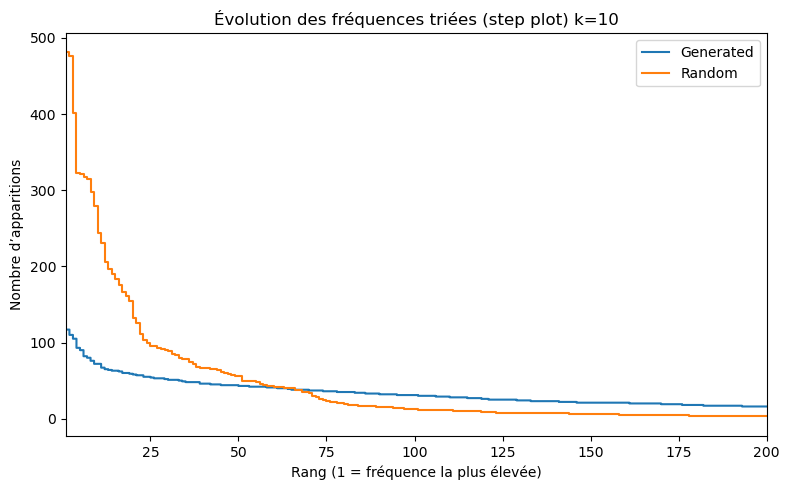

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# (Re)construisons vos listes triées si besoin
freqs_gen_sorted  = sorted(list(counts_gen.values()),  reverse=True)
freqs_rand_sorted = sorted(list(counts_rand.values()), reverse=True)

# Abscisses discrètes (rangs 1,2,3,…)
x_gen  = np.arange(1, len(freqs_gen_sorted) + 1)
x_rand = np.arange(1, len(freqs_rand_sorted) + 1)

plt.figure(figsize=(8,5))
# tracé en escalier — ici 'post' pour garder la valeur jusqu'au prochain point
plt.step(x_gen,  freqs_gen_sorted,  where='post', label='Generated')
plt.step(x_rand, freqs_rand_sorted, where='post', label='Random')

plt.xlabel('Rang (1 = fréquence la plus élevée)')
plt.ylabel('Nombre d’apparitions')
plt.title(f'Évolution des fréquences triées (step plot) k={K}')
plt.legend()
plt.xlim(1, 200)
plt.tight_layout()
plt.show()

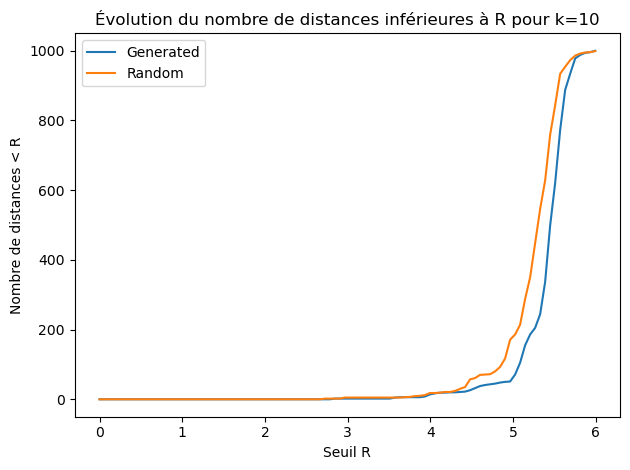

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Si vos distances sont des listes Python :
dist_gen = np.array(distances_gen)
dist_rand = np.array(distances_rand)

# Choix des valeurs de seuil R
R_max = max(dist_gen.max(), dist_rand.max())
R_values = np.linspace(0, R_max, 100)

# Comptage du nombre d'éléments < R pour chaque R
counts_gen_g = [np.sum(dist_gen < R) for R in R_values]
counts_rand_g = [np.sum(dist_rand < R) for R in R_values]

# Tracé
plt.figure()
plt.plot(R_values, counts_gen_g, label='Generated')
plt.plot(R_values, counts_rand_g, label='Random')
plt.xlabel('Seuil R')
plt.ylabel('Nombre de distances < R')
plt.legend()
plt.title(f'Évolution du nombre de distances inférieures à R pour k={K}')
plt.tight_layout()
plt.show()
